US Treasury Bond Futures Trading Strategy Report

Author: Yi Rong

In [1]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import performanceanalytics.statistics as pas

-------------------------------- Data Processing and Strategy Development --------------------------------

In [2]:
# download daily data from quandl, data period from 1977 to now
US = quandl.get("CHRIS/CME_US1", authtoken="6x2d-jwB8rkP_o3bPsXh")

In [3]:
# separate data into two parts: training set and testing set
US1 = US.loc[US.index < '2017-01-01']
US2 = US.loc[US.index >= '2017-01-01']

In [61]:
US1 = pd.DataFrame(US1['Settle'])
US2 = pd.DataFrame(US2['Settle'])

In [27]:
# compute max Drawdown
def mdd(data):
    # data: a pandas series of returns
    
    returns = data
    r = returns.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    MDD = -dd.min()

    return MDD

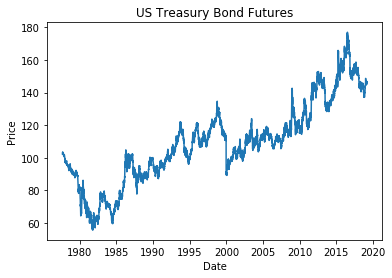

In [53]:
plt.plot(US.index, US['Settle']) 
plt.xlabel('Date')
plt.ylabel('Price') 
plt.title('US Treasury Bond Futures')
plt.show()

Strategy Idea: Because the graph above shows an obvious upward trend for a long time and the only choice for the position is 100% long or 100% short, the strategy will mainly keep a long position and control risk with a stop loss threshold. The stop loss is trailing the max price at a certain time length. Once the threshold is broken, the position will be changed to short in the next trading day. When the price goes beyond the threshold, the position will reverse to a long position. The strategy is simple, but the difficult part is how to determine the two parameters, which are threshold and rolling length.

In [43]:
# Stop Loss Strategy
def Stop_Loss_Strategy(data, rolling_length, threshold):
    # data: must include one column named 'Settle'
    # rolling_length: time length to compute max price
    # threshold: max loss for a long position
    
    Position = [None] * len(data) # only shows 1 or -1
    Rolling_Max = [None] * len(data) # max price in the rolling length
    LossfromTop = [None] * len(data) # loss from rolling max
    
    # calculate rolling max and loss from top
    for i in range(len(data) - rolling_length):
        Rolling_Max[i + rolling_length - 1] = max(data['Settle'][i : i + rolling_length - 1])
        LossfromTop[i + rolling_length - 1] = 1 - data['Settle'][i + rolling_length - 1] / Rolling_Max[i + rolling_length - 1]
        
        # if loss is rising over the threshold, open a short position in the next trading day
        if LossfromTop[i + rolling_length - 1] > threshold:
            Position[i + rolling_length] = - 1
        
        # otherwise, keep a long position
        else:
            Position[i + rolling_length] = 1
            
    data['Rolling_Max'] = Rolling_Max  
    data['Loss from Top'] = LossfromTop
    data['Position'] = Position
    data['Daily Returns'] = data.Settle.pct_change()
    data['Strategy Returns'] = data['Position'] * data['Daily Returns']
    
    # calculate sortino ratio, annual return, and max Drawdown
    sortino_ratio = pas.sortino_ratio(data['Strategy Returns'].dropna().values, rf = 0)
    annual_return = data['Strategy Returns'].mean() * 252
    maxDrawdown = mdd(data['Strategy Returns'])
    
    # compute a performance indicator involving all three results
    return sortino_ratio * annual_return / maxDrawdown

The measurement of the strategy will consider all sortino ratio, annual return and max Drawdown and put them together in a function. The function is shown above.

------------------------------------------------------------------- Strategy Optimization -------------------------------------------------------------------

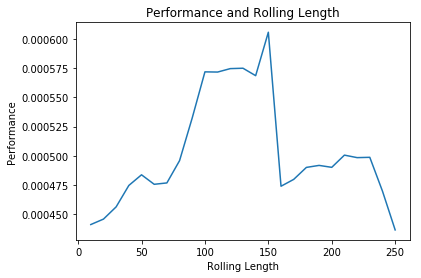

In [55]:
# find the best value for rolling length
rlength = np.arange(10, 260, 10)
rlength_impact = [None] * len(rlength)
for i in range(len(rlength)):
    rlength_impact[i] = Stop_Loss_Strategy(US1, rlength[i], 0.3)
    
plt.plot(rlength, rlength_impact) 
plt.xlabel('Rolling Length')
plt.ylabel('Performance') 
plt.title('Performance and Rolling Length')
plt.show()

The result above is a convex shape, indicating it is meaningful to optimize the rolling length. Because the best performance is unique, the best value for rolling length can be determined as 150. This value will be verified again.

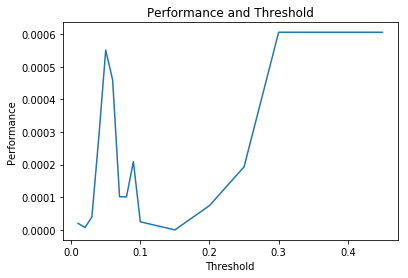

In [56]:
# find the best value for threshold
threshold = np.concatenate([np.arange(0.01, 0.11, 0.01), np.arange(0.1, 0.5, 0.05)])
threshold_impact = [None] * len(threshold)
for i in range(len(threshold)):
    threshold_impact[i] = Stop_Loss_Strategy(US1, 150, threshold[i])

plt.plot(threshold, threshold_impact) 
plt.xlabel('Threshold')
plt.ylabel('Performance') 
plt.title('Performance and Threshold')
plt.show()

There are two local best thresholds in the graph. The left one is 0.05 and the right one is 0.3. The performance for the left threshold is extremelt high, which looks like an occasion. Next, I will further testify the value of 0.05.

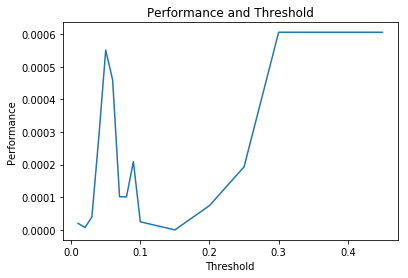

In [72]:
threshold = np.concatenate([np.arange(0.01, 0.11, 0.01), np.arange(0.1, 0.5, 0.05)])
threshold_impact = [None] * len(threshold)
for i in range(len(threshold)):
    threshold_impact[i] = Stop_Loss_Strategy(US1, 150, threshold[i])
    
plt.plot(threshold, threshold_impact) 
plt.xlabel('Threshold')
plt.ylabel('Performance') 
plt.title('Performance and Threshold')
plt.show()

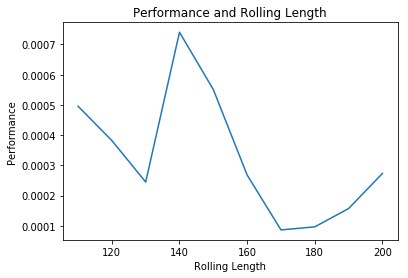

In [59]:
rlength = np.arange(110, 210, 10)
rlength_impact = [None] * len(rlength)
for i in range(len(rlength)):
    rlength_impact[i] = Stop_Loss_Strategy(US1, rlength[i], 0.05)
    
plt.plot(rlength, rlength_impact) 
plt.xlabel('Rolling Length')
plt.ylabel('Performance') 
plt.title('Performance and Rolling Length')
plt.show()

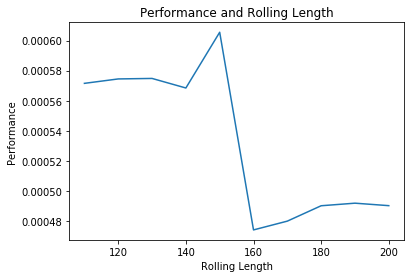

In [60]:
rlength = np.arange(110, 210, 10)
rlength_impact = [None] * len(rlength)
for i in range(len(rlength)):
    rlength_impact[i] = Stop_Loss_Strategy(US1, rlength[i], 0.3)
    
plt.plot(rlength, rlength_impact) 
plt.xlabel('Rolling Length')
plt.ylabel('Performance') 
plt.title('Performance and Rolling Length')
plt.show()

The first result using 0.05 as threshold is quite volatile, because the performance jumps from 0.0007 to 0.0001. But for the second result, the performance is much more stable. Hence, the threshold should be determined as 0.3.

------------------------------------------------------------------- Results in Testing Set -------------------------------------------------------------------

In [78]:
# Performance in the testing set
Testing_Performance = Stop_Loss_Strategy(US2, 150, 0.3)

In [79]:
# Performance for the benchmark
returns = US2.Settle.pct_change()
sortino_ratio = pas.sortino_ratio(returns.dropna().values, rf = 0)
annual_return = returns.mean() * 252
maxDrawdown = mdd(returns)

In [80]:
Benchmark_Performance = sortino_ratio * annual_return / maxDrawdown
Training_Performance = Stop_Loss_Strategy(US1, 150, 0.3)

In [92]:
Result = {'Testing Performance' : Testing_Performance, 'Benchmark Performance' : Benchmark_Performance, 'Training Performance' : Training_Performance}
Result

{'Testing Performance': 0.011804828581230198,
 'Benchmark Performance': 0.0018239282037566906,
 'Training Performance': 0.0006055462524477559}

The strategy performance in Testing set is much better than the benchmark performance and also outperforms Training Performance. The validation of the strategy is verified.

But in the real money business, the model should consider trading cost, slippage and better risk control method.